In [1]:
from fenics import *
from dolfin_adjoint import *
import pygmsh_mesh_functions
from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt

import skimage.io
from skimage.measure import find_contours, subdivide_polygon, approximate_polygon

In [2]:
def hole_polygon(domain, polygon):
    tool = add_polygon(polygon)
    domain = subtract(domain, tool)

In [3]:
def arrange_array(n_holes_x, n_holes_y, d_x, d_y,
                  freq = 1, phase = 0, shift = np.array([0,0]), twist = 0):
    
    min_n_holes = np.min((n_holes_x,n_holes_y))

#     xx = scale*(np.arange(n_holes_x)-n_holes_x/2+0.5)/size+0.5
#     yy = scale*(np.arange(n_holes_y)-n_holes_y/2+0.5)/size+0.5
    xx = (np.arange(n_holes_x)-n_holes_x/2+0.5)*d_x+0.5
    yy = (np.arange(n_holes_y)-n_holes_y/2+0.5)*d_y+0.5
    cx,cy = np.meshgrid(xx,yy)
    
    cx = cx.reshape(n_holes_x*n_holes_y)
    cy = cy.reshape(n_holes_x*n_holes_y)
    c = np.vstack((cx,cy)) # hole coordinate

    s_xx = (-1)**np.arange(n_holes_x)
    s_yy = (-1)**np.arange(n_holes_y)
    sgn_x,sgn_y = np.meshgrid(s_xx,s_yy)
    sgn = sgn_x*sgn_y
    sgn = sgn.reshape(n_holes_x*n_holes_y)
    theta = np.pi*(sgn/2)*freq + phase # hole orientation
    theta = theta + (np.random.rand(len(theta))-0.5)*twist
    
    return(c, theta)

## Generate holes

### define parameters

In [4]:
A = np.array([1.0,0.75,0.01])
margin = 0.2

### preview tools

(-0.25, 1.25)

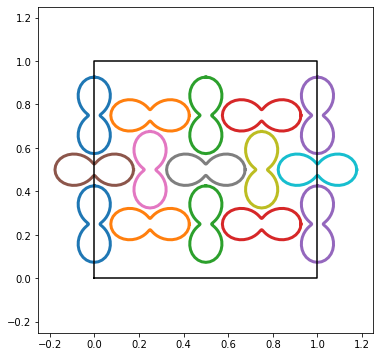

In [5]:
# arrange the tools
size = 4
c, theta = arrange_array(5, 3, 1/size, 1/size, freq = 1/2, phase = np.pi/4)

# define tools
n_phi = 60
phi = np.arange(n_phi+1)/n_phi*2*np.pi
scale = 1/size/2*(1-margin)

r = np.zeros((2,n_phi+1))
for i in range(len(A)):
    ri = np.array([np.cos(phi), np.sin(phi)])*np.cos(2*(i)*phi)*A[i]
    r = r+ri
# r = r/np.sum(A)
r = r*scale

# plot arranged tools
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(theta)):
    co, so = np.cos(theta[i]), np.sin(theta[i])
    Rotation = np.array(((co, -so), (so, co)))
    ri = Rotation@r
    ax.plot(ri[0,:] + c[0,i], ri[1,:] + c[1,i],'-',linewidth=3)
  
ax.plot([0,1,1,0,0],[0,0,1,1,0],'-k')
ax.set_xlim([-0.25,1.25])
ax.set_ylim([-0.25,1.25])

## Generate Mesh

Info    : Running '/home/fenics/.local/bin/gmsh -3 /tmp/tmptyxuj0ba.geo -format msh -bin -o /tmp/tmphzmxyhg4.msh' [Gmsh 4.9.5, 1 node, max. 1 thread]
Info    : Started on Wed May 18 17:17:27 2022
Info    : Reading '/tmp/tmptyxuj0ba.geo'...
Info    : Done reading '/tmp/tmptyxuj0ba.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 2705 (Line)
Info    : [ 10%] Meshing curve 2706 (Line)
Info    : [ 10%] Meshing curve 2707 (Line)
Info    : [ 10%] Meshing curve 2708 (Line)
Info    : [ 10%] Meshing curve 2709 (Line)
Info    : [ 10%] Meshing curve 2710 (Line)
Info    : [ 10%] Meshing curve 2711 (Line)
Info    : [ 10%] Meshing curve 2712 (Line)
Info    : [ 10%] Meshing curve 2713 (Line)
Info    : [ 10%] Meshing curve 2714 (Line)
Info    : [ 10%] Meshing curve 2715 (Line)
Info    : [ 10%] Meshing curve 2716 (Line)
Info    : [ 10%] Meshing curve 2717 (Line)
Info    : [ 10%] Meshing curve 2718 (Line)
Info    : [ 10%] Meshing curve 2719 (Line)
Info    : [ 10%] Meshing curve 2720 (Line)
In

4192

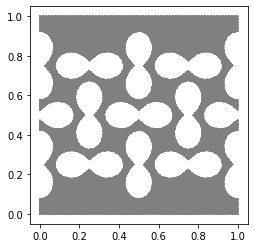

In [6]:
Lx = 1
Ly = 1

meshsize_min = 0.015
meshsize_max = 0.015

pygmsh_mesh_functions.hmeshmin = meshsize_min
pygmsh_mesh_functions.hmeshmax = meshsize_max

reset_geometry()

domain = add_polygon([(0, 0), (Lx, 0), (Lx, Ly), (0, Ly)])
X0 = np.array([0, 0])

#OPERATIONS ON DOMAIN
for i in range(len(theta)):
    co, so = np.cos(theta[i]), np.sin(theta[i])
    Rotation = np.array(((co, -so), (so, co)))
    
    polygon = (Rotation@r).T
    polygon = polygon[:-1]

    polygon_subdivide = subdivide_polygon(polygon, degree=2, preserve_ends=True)
    polygon_approx = approximate_polygon(polygon_subdivide,0.0025)
    polygon_shift = polygon_approx + c[:,i]

    hole_polygon(domain, polygon_shift)

#CREATE AND STORE MESH
sample_name = "test_loop_array_2fold_{}_{}_{}.xdmf".format(A[0],A[1],A[2])
out_dir = pathlib.Path("output_files")
out_dir.mkdir(parents=True, exist_ok=True)
mesh = create_fenics_mesh(mesh_path = out_dir / sample_name, verbose=True)
cell_type = mesh.cell_name()
with create_XDMFFile(out_dir / sample_name) as xf:
    xf.write(mesh)
    
plot(mesh)
len(mesh.coordinates())